<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeperfont/fonttools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888
from enum import Enum, IntEnum
from copy import copy
import math
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageChops
from IPython.display import display
print(np.__version__)
print(tf.__version__)
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

#!pip install triangle
import triangle as tr

#!pip install fonttools
#from fontTools.ttLib import TTFont

# should be:
#!pip install ttfquery
# or 
#!conda install -c mwcraig ttfquery
# but actually had to:
#git clone git@github.com:mindw/ttfquery.git
#cd ttfquery
#python setup.py install

import ttfquery.describe
import ttfquery.glyph
import ttfquery.findsystem

#!pip install shapely
# or on windows:
#!conda config --add channels conda-forge
#!conda install shapely
import shapely.ops
import shapely.geometry
import shapely.affinity

#!pip install descartes
import descartes

C:\Users\terry\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.14.2
1.10.0


In [0]:
def readFonts(files: [str], glyphs: str): # type: List(List[MultiPolygon))
  print('loading {} files'.format(len(files)))
  tolerance = 0.001
  fonts = []
  for fontfile in files:
    font = ttfquery.describe.openFont(fontfile)
    multipolys = []
    for glyph in glyphs:
      g = ttfquery.glyph.Glyph(glyph)
      g.compile(font, steps=2)
      contours = [shapely.geometry.LinearRing(contour) for contour in g.outlines]
      #contours = [shapely.geometry.LinearRing(contour) for contourflags in g.calculateContours(font) for contour, flag in contourflags]
      size = 1.0
      contours = [shapely.affinity.scale(contour, size/g.height, size/g.height, origin=(0,0.1))
                  for contour in contours]
      polys = []
      holes = []
      # Find contours inside other contours and make them holes
      for contour in contours:
        for i, poly in enumerate(polys):
          if shapely.geometry.Polygon(contour).contains(shapely.geometry.Polygon(poly)):
            #replace
            polys[i] = contour
            holes[i].append(poly)
            break
          elif shapely.geometry.Polygon(poly).contains(shapely.geometry.Polygon(contour)):
            holes[i].append(contour)
            break
        else:
          polys.append(contour)
          holes.append([])
      multipolys.append(shapely.geometry.MultiPolygon(
          [shapely.geometry.Polygon(poly, hole).simplify(tolerance) for poly, hole in zip(polys, holes)]))
    fonts.append(multipolys)
  return fonts

In [3]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('I')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('i')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs += ['one','two','one','two']
#glyphs = ['A'] + glyphs
#glyphs = ['A','B','i','g','eight']
#glyphs = ['A']
max_outline_points = 200
files = glob.glob('deeper/fonts/*.ttf')
files = list(ttfquery.findsystem.findFonts())[0:5]
print(files)
fonts = readFonts(files, glyphs)
#print(fonts[0][0])
#drawOutlines(vertices, segments, )

setup...
['c:\\windows\\fonts\\arial.ttf', 'c:\\windows\\fonts\\ariblk.ttf', 'c:\\windows\\fonts\\arialbd.ttf', 'c:\\windows\\fonts\\arialbi.ttf', 'c:\\windows\\fonts\\ariali.ttf']
loading 5 files


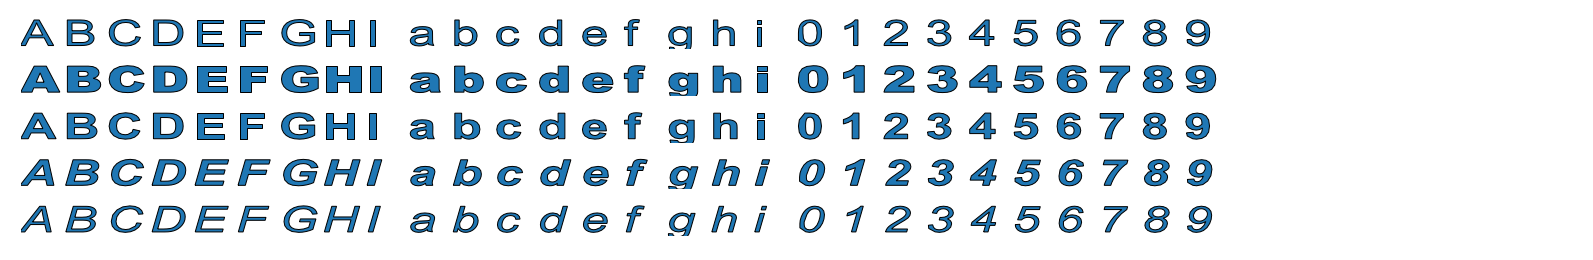

In [4]:
def drawMultiPolygons(polygons):
  fonts = len(polygons)
  glyphs = max([len(polygon) for polygon in polygons])
  plt.figure(figsize=(glyphs,fonts))
  for f in range(fonts):
    ax = plt.subplot(fonts+1, 1, 1+f)
    ax.set_xlim(0, glyphs+1)
    ax.set_axis_off()
    for glyph in range(glyphs):
      ax.add_patch(descartes.PolygonPatch(
          shapely.affinity.translate(polygons[f][glyph], glyph*0.8)
      ))
  plt.show()

drawMultiPolygons(fonts)


In [0]:
# Shapely triangulation doesn't handle holes, so use tr module instead
#triangles = shapely.ops.triangulate(fonts[0][0])

def add_multiline(coords, vertices, segments):
  start = len(vertices)
  vertices += coords[:-1]
  segments += [(i, i+1) for i in range(start, start+len(coords)-2)]
  segments.append((start+len(coords)-2, start))
  
nptris = np.empty((len(fonts), len(glyphs)), dtype=dict)
for f in range(len(fonts)):
  for g in range(len(glyphs)):
    vertices = []
    segments = []
    holes = []
    for poly in fonts[f][g]:
      add_multiline(poly.exterior.coords, vertices, segments)
      for interior in poly.interiors:
        add_multiline(interior.coords, vertices, segments)
        holes.append(shapely.geometry.Polygon(interior).representative_point().coords[:])
    T = {
      'vertices': np.array(vertices),
      'segments': np.array(segments),
    }
    if holes:
      T['holes'] = np.array(holes).reshape((-1,2))

    nptris[f,g] = tr.triangulate(T, opts='p')
    #print(f, g, len(vertices), nptris[f,g]['triangles'].shape)
  #plt.figure(figsize=(50,2))
  # tr.plot(ax,
  #         vertices=[p for poly in triangles for p in poly.exterior.coords],
  #         triangles=[(i, i+1, i+2) for i in range(len(triangles))]
  #        )
  # for i,poly in enumerate(triangles):
  #   ax = plt.subplot(1, len(triangles), 1+i)
  #   ax.add_patch(descartes.PolygonPatch(poly))
  #plt.show()

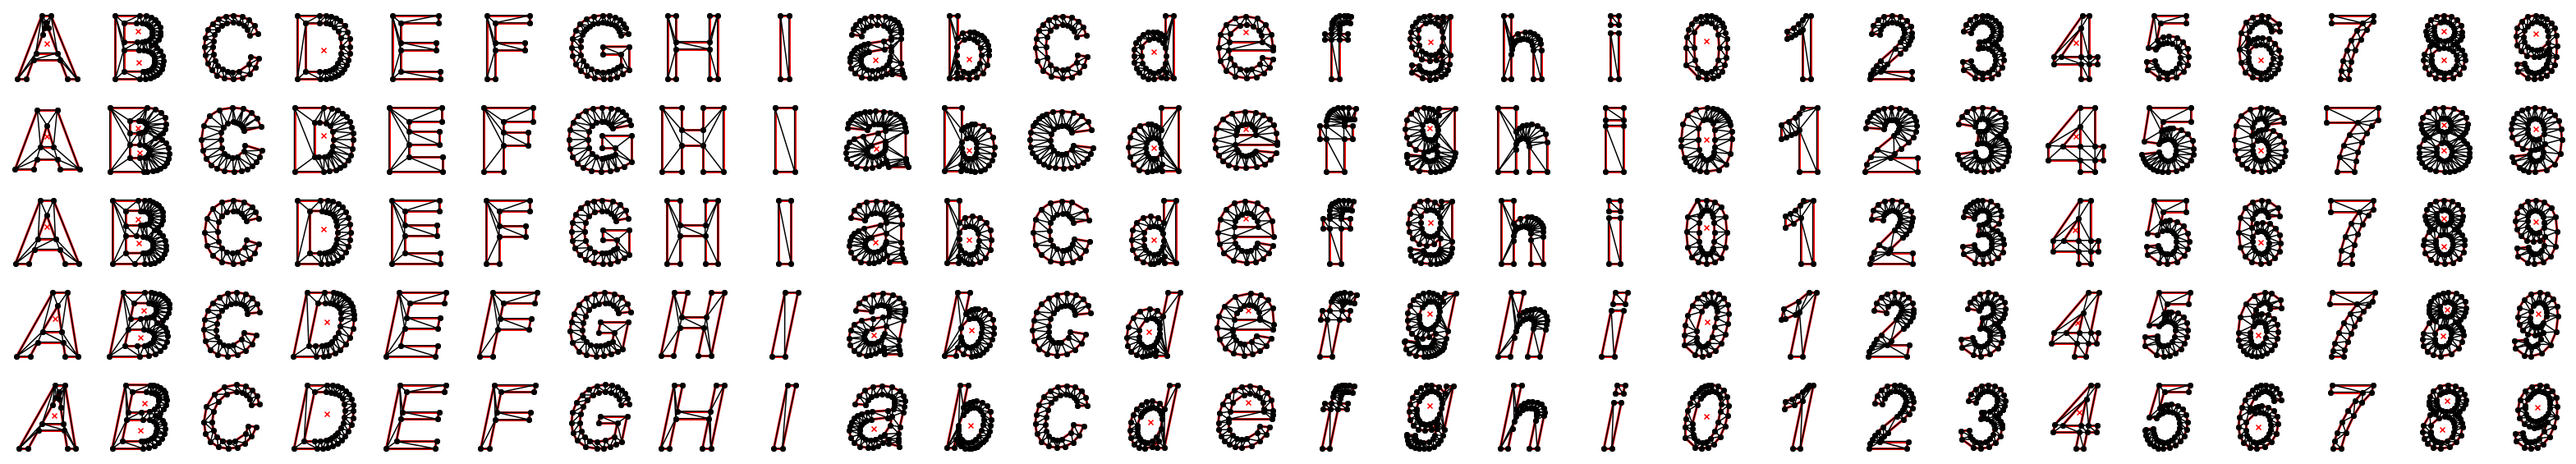

In [6]:
def drawTris(nptris):
  shape = nptris.shape
  plt.figure(figsize=(shape[1]*2,shape[0]*2))
  for f in range(shape[0]):
    for g in range(shape[1]):
      if nptris[f,g]:
        ax = plt.subplot(shape[0], shape[1], f*shape[1]+g+1)
        #ax.set_xlim(0, shape[1]+1)
        ax.set_axis_off()
        tr.plot(ax, **nptris[f,g])
        #ax.add_patch(descartes.PolygonPatch(
        #  shapely.affinity.translate(polygons[font][glyph], glyph*0.8)
        #))
  #plt.tight_layout()
  plt.show()

drawTris(nptris)


In [7]:
f,g=0,8
print(nptris[f,g]['triangles'])
counts = np.bincount(nptris[f,g]['triangles'].flatten())
print(counts)
print(counts.argmin())
print(np.bincount(nptris[f,g]['triangles'].flatten()).sum())

[[1 0 3]
 [3 2 1]]
[1 2 1 2]
0
6



add_triangles
[[-0.    0.1 ]
 [ 0.25  0.76]
 [ 0.34  0.76]
 [ 0.61  0.1 ]
 [ 0.52  0.1 ]
 [ 0.44  0.3 ]
 [ 0.16  0.3 ]
 [ 0.09  0.1 ]
 [ 0.19  0.37]
 [ 0.41  0.37]
 [ 0.32  0.63]
 [ 0.3   0.69]
 [ 0.28  0.63]
 [ 0.26  0.56]]
[[ 0  7  6]
 [ 9  8  6]
 [ 0  6  8]
 [ 8  1  0]
 [ 1  8 13]
 [13 12  1]
 [ 1 12 11]
 [ 5  4  3]
 [ 5  3  9]
 [11 10  2]
 [ 2  9  3]
 [ 9  2 10]
 [11  2  1]
 [ 5  9  6]]
[3 5 4 3 1 3 4 1 4 5 2 3 2 2]
add: v4, [0.52 0.1 ], c=1
matches [0 0 0 0 0 0 0 1 0 0 0 0 0 0] 7 [5 4 3]
[   3 9999    3] 0 5
add: v5, [0.44 0.3 ], c=3
matches [0 0 0 0 0 0 0 1 1 0 0 0 0 1] 7 [5 4 3]
[9999 9999    3] 2 3
add: v3, [0.61 0.1 ], c=3
matches [0 0 0 0 0 0 0 1 0 1 0 0 0] 7 [5 3 9]
[9999 9999    5] 2 9
add: v9, [0.41 0.37], c=5
matches [0 1 0 0 0 0 0 0 1 1 0 1] 1 [9 8 6]
[9999    4    4] 1 8
add: v8, [0.19 0.37], c=4
matches [0 1 1 1 1 0 0 0 0 0 0 0] 1 [9 8 6]
[9999 9999    4] 2 6
add: v6, [0.16 0.3 ], c=4
matches [1 1 0 0 0 0 0 0 0 0] 0 [0 7 6]
[   3    1 9999] 1 7
add: v7, [0.09 0.1 ], c

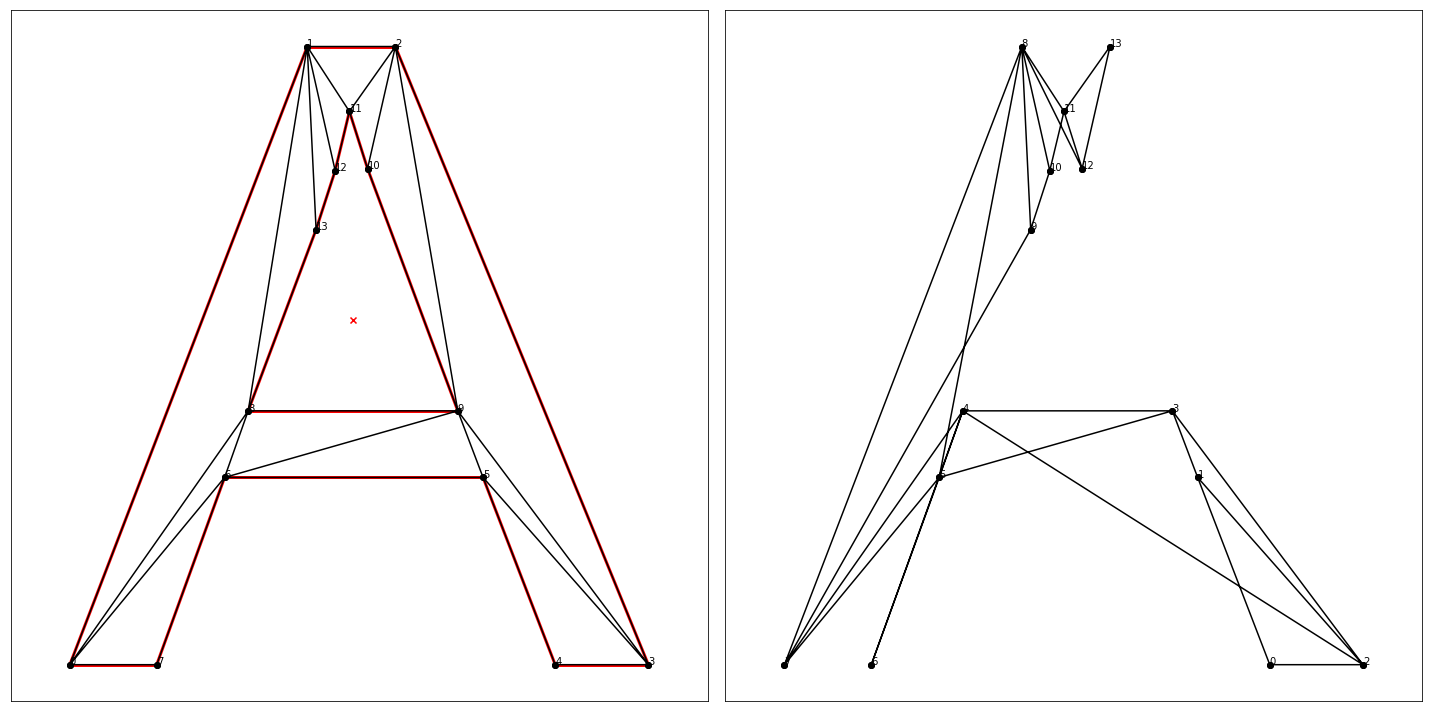

In [8]:
class TriangleStack(object):
  def __init__(self):
    self._vertices = []
    self._vertex_use_counts = []
    self.MAXINT = 9999
    
  def get_triangles(self):
    print("\ndisplay")
    out_triangles = []
    this_triangle = []
    unused_vertex_indices = range(len(self._vertices))
    vertex_use_counts = copy(self._vertex_use_counts)
    print("vertex_use_counts: ", vertex_use_counts)
    
    for vi, v in enumerate(unused_vertex_indices):
      this_triangle.append(v)
      print(vi, v, this_triangle)
      
      if len(this_triangle)==3:
        out_triangles.append(this_triangle)
        print("out: ", out_triangles)
        for i in this_triangle:
          vertex_use_counts[i] -= 1
        print("vertex_use_counts: ", vertex_use_counts)
        this_triangle = []
        for i in reversed(range(vi+1)):
          if vertex_use_counts[i]>0:
            this_triangle.append(i)
            if len(this_triangle)==2:
              break
        print(this_triangle)
    return {'vertices': triStack._vertices, 'triangles': out_triangles}

    
  def add_triangles(self, nptri):
    print("\nadd_triangles")
    def add(vertex, triangleCount):
      self._vertices.append(vertex)
      self._vertex_use_counts.append(triangleCount)
    vertices = nptri['vertices']
    triangles = nptri['triangles']
    print(vertices)
    print(triangles)
    vertex_use_counts = np.bincount(triangles.flatten())
    print(vertex_use_counts)
    index = vertex_use_counts.argmin()
    while(vertex_use_counts.min()<self.MAXINT):
      assert vertex_use_counts[index]!=self.MAXINT
      print("add: v%d, %s, c=%d" % (index, vertices[index], vertex_use_counts[index]))
      add(vertices[index], vertex_use_counts[index])
      vertex_use_counts[index] = self.MAXINT
      # print("vertex_use_counts: ", vertex_use_counts)
      unfinished_triangles = triangles[vertex_use_counts[triangles].min(axis=1)!=self.MAXINT]
      if not unfinished_triangles.size:
        break
      matches = (unfinished_triangles==index).sum(axis=1)
      triangle_index = matches.argmax()
      matching_triangle = unfinished_triangles[triangle_index]
      print("matches", matches, triangle_index, matching_triangle)
      triangle_counts = vertex_use_counts[matching_triangle]
      tri_vert_index = triangle_counts.argmin()
      index = matching_triangle[tri_vert_index]
      print(triangle_counts, tri_vert_index, index)

triStack = TriangleStack()
glyph = nptris[0,0]
triStack.add_triangles(glyph)
triangles = triStack.get_triangles()

glyph['labels']=1
triangles['labels']=1
tr.compare(plt, glyph, triangles, figsize=(20,10))
plt.show()


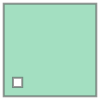

False
True


In [9]:
# debugging shapely contains()
g1=shapely.geometry.LinearRing([(0, 0), (10, 0), (10, 10), (0,10)])
g2=shapely.geometry.LinearRing([(1,1),(2,1),(2,2),(1,2)])
display(shapely.geometry.Polygon(g1, [g2]))
print(g2.within(g1))  # ==False: see https://github.com/Toblerity/Shapely/issues/275
print(shapely.geometry.Polygon(g2).within(shapely.geometry.Polygon(g1))) # ==True

In [10]:
#points = shapely.geometry.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
print([(A["vertices"][s], A["vertices"][e]) for s,e in A["segments"]])
points = shapely.geometry.MultiPoint([A["vertices"][s] for s,e in A["segments"]])
triangles = shapely.ops.triangulate(points)
print([triangle.wkt for triangle in triangles])

ax1 = plt.subplot(122)
tr.plot(ax1,
        vertices=[p for poly in triangles for p in poly.exterior.coords],
        triangles=[(i, i+1, i+2) for i in range(len(triangles))]
       )
for poly in triangles:
  ax1.add_patch(descartes.PolygonPatch(poly))
# plt.show()

#fig = plt.figure(1, figsize=(5,5), dpi=90)
ring_mixed = shapely.geometry.Polygon([(0, 0), (0, 1.8), (1, 1), (.5, .5), (.5, 0), (1, 0.8), (0, 0)])
#ax = fig.add_subplot(111)
ax = plt.subplot(121)
ax.add_patch(descartes.PolygonPatch(ring_mixed))

plt.show()

NameError: ignored

In [0]:
# Sample from https://rufat.be/triangle/API.html

#A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = tr.get_data('A')
del A['vertex_attributes']
print(A.keys())
B = tr.triangulate(A, opts='p')
tr.compare(plt, A, B)
# #plt.figure()
# ax1 = plt.subplot(121)
# tr.plot(ax1, **A)
# lim = ax1.axis()
# ax2 = plt.subplot(122, sharey=ax1)
# tr.plot(ax2, **B)
# ax2.axis(lim)
# plt.tight_layout()
plt.show()